# Performing in processing bias migitagation with Gerry Fair Classifier on German Credit Dataset #
In this example, we will show the bias in the dataset for German Credits regarding the age. To pharaphrase in the dataset, disregarding all other features, people younger than 25 are less likely to be granted a loan). After that we will train a superivised learning model based on the biased dataset without any migitaition measure. The model will then be evaluated for statistical parity difference. 

Lastly, Gerry Fair Classifier which mitigates the bias in the training of the machine learning model (thus in process migtigation) is trained and the results in statistial parity difference are compared.

For details about the Gerry Fair Classifier it in in this paper https://proceedings.mlr.press/v80/kearns18a.html. GerryFairClassifier attempts to fix fairness gerrymandering with defining respect to rich classes of subgroups many/possibily infite subgroups and provided a exponential algorithm to calculate fairness for subgroups. The algorithm is based on a formulation of subgroup fairness as a zero-sum game between a Learner (the primal player) and an Auditor (the dual player). 

### [done] Improvements to be made
1. Where is the bias coming from in this particular example 
2. May be other protected attributes than Age 
3. use in-processing mitigation instead (they uses pre-processing)
4. more fairness matrices or more visualization of it 
5. explain the supervised learning algorithm used clearer


### Steps in the tutorial
1. Installing required packages 
2. Loading the dataset and studying the dataset.
3. Demonstrating bias in the dataset for age two groups younger than 25 and equal or older than 25.
4. The ML models can learn this bias.
5. Migitating bias using GerryFairClassifier in process migitation.
6. Demonstrating the bias removal


## Step 1: Installing required packages
Installing Aif360 on Anaconda.
Open conda prompt and run.

    conda install -c conda-forge aif360 fairlearn

## Step 2: Loading the dataset ##

In order to get the German Credit Dataset, download the following files when prompted and put it in the folder that is specified in the error messages. 

USE OUR VERSION OF THE GERMAN DATASET.
We have to use our version of the German Dataset which the labelled are set to 0 and 1 (instead of 1 and 2) so that GerryFairClassifier will work. 

It can be curretly downloaded here.

### Copy OUR german dataset ### 
On the first time of loading the German dataset, you will be promoted to download the dataset from the source and put it in the correct folder. 
Our example requires a slightly modified version of the German credit dataset. Therefore, copy data/german from our example folder and put it in the folder prompted. 

The folder is usually [anacondabase]\Lib\site-packages\aif360\data\raw\german

The fields in the german dataset are.
['status', 'month', 'credit_history',
    'purpose', 'credit_amount', 'savings', 'employment',
    'investment_as_income_percentage', 'personal_status',
    'other_debtors', 'residence_since', 'property', 'age',
    'installment_plans', 'housing', 'number_of_credits',
    'skill_level', 'people_liable_for', 'telephone',
    'foreign_worker']

And the label is 0 for not being creditworth and 1 for credit worthiness.



### Age is the protected attribute in our example. 
By default, this code converts the ‘age’ attribute to a binary value where privileged is age >= 25 and unprivileged is age < 25 as proposed by Kamiran and Calders.



In [78]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Load all necessary packages
import sys
sys.path.insert(1, "../")  
from IPython.display import Markdown, display

import numpy as np
import pandas as pd

from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.inprocessing import GerryFairClassifier

from common_utils import extract_df_from_ds


In [79]:
# the german dataset where is the bias coming from
# source is https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29 
# a small dataset with 20 attributes and 1000 samples 
# the attributes are as follows

#dataset_german = GermanDataset()

modified_mappings = {
    'label_maps': [{0.0: 'Good Credit', 1.0: 'Bad Credit'}],
    'protected_attribute_maps': [{1.0: 'Old', 0.0: 'Young'}],
}

dataset_german = GermanDataset(
    protected_attribute_names=['age'],           # this dataset also contains protected
                                                 # attribute for "sex" which we do not
                                                 # consider in this evaluation
    privileged_classes=[lambda x: x >= 25],      # age >=25 is considered privileged
    features_to_drop=['personal_status', 'sex'], # ignore sex-related attributes
    metadata=modified_mappings ## IMPORTANT set the mappings correctly
)

In [80]:
dataset_german.feature_names, dataset_german.label_names

(['month',
  'credit_amount',
  'investment_as_income_percentage',
  'residence_since',
  'age',
  'number_of_credits',
  'people_liable_for',
  'status=A11',
  'status=A12',
  'status=A13',
  'status=A14',
  'credit_history=A30',
  'credit_history=A31',
  'credit_history=A32',
  'credit_history=A33',
  'credit_history=A34',
  'purpose=A40',
  'purpose=A41',
  'purpose=A410',
  'purpose=A42',
  'purpose=A43',
  'purpose=A44',
  'purpose=A45',
  'purpose=A46',
  'purpose=A48',
  'purpose=A49',
  'savings=A61',
  'savings=A62',
  'savings=A63',
  'savings=A64',
  'savings=A65',
  'employment=A71',
  'employment=A72',
  'employment=A73',
  'employment=A74',
  'employment=A75',
  'other_debtors=A101',
  'other_debtors=A102',
  'other_debtors=A103',
  'property=A121',
  'property=A122',
  'property=A123',
  'property=A124',
  'installment_plans=A141',
  'installment_plans=A142',
  'installment_plans=A143',
  'housing=A151',
  'housing=A152',
  'housing=A153',
  'skill_level=A171',
  'skill_

## 3. Demonstrating bias in the dataset regarding age groups. ##

To measure the bias in the dataset, We will use BinaryLabelDatasetMetric on the dataset. BinaryLabelDatasetMetric can be used on datasete where the unprivileged group and privileged groups are labelled by binary value 0 or 1. The age attribute in our dataset is encoded to be

* privileged group age > 25 as 1 
* unprivileged groups age <= 25 as 0
    
Mean_difference is the statistical parity difference. Mean_difference computers the differences in value between probablity of favourable outcome (that is to be classified as good credit application with favourable label 1) between unprivileged and privileged groups in the dataset. It is computed using the formula below.
Pr(Y^=pos_label|D=unprivileged)−Pr(Y^=pos_label|D=privileged)

In our training dateset, the mean_difference value is 0.193645 meanting that in the data the probablity of unprevileged group getting their loan approved is around 19% lower than that of the privileged group! Note that mean_diference value will be slightly different for each selection of the training dataset. It is because selecting 70% of the dataset to train the data on is random everytime it is there. However, the bias will still be approximately around 0.2%. 


In [81]:
#splitting into training and test set
dataset_train, dataset_test = dataset_german.split([0.7], shuffle=True)

privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

In [82]:
# Detecting bias in the original dataset
# Class for computing metrics based on a single BinaryLabelDataset.
#provileged gropp are people over 25 
#unprovileged groups are people under 25
# mean_difference computes the statistical parity difference

# Pr(Y=1|D=unprivileged)−Pr(Y=1|D=privileged)
# statistical parity is one of the dimension of fairness in a dataset. 


metric_orig_train = BinaryLabelDatasetMetric(dataset_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)


metric_german = BinaryLabelDatasetMetric(dataset_german, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)


display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

print("Mean ourcomes differences between unprivileged and privileged groups = {}".format(metric_german.mean_difference()))

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.146995
Mean ourcomes differences between unprivileged and privileged groups = -0.12854990969960323


In [83]:
x_german, xprime_german, y_german = extract_df_from_ds(dataset_german)
x_german['label'] = y_german
x_german['label'].value_counts()

1.0    700
0.0    300
Name: label, dtype: int64

TODO may be try what would happene if we train a model on it without any migitation measure?

## 4. Supervised learning with biased datasets ##
Supervised leraning is a goroup of machine learning methods that uses the training data and learns how to map the features and label(s) pairs. In our case, we can use the German Credit Dataset to train a supervised learning model that predits whether is a person described by features listed above is credit worthy or not. 

However, we have demonstrated that the data is biased towards young people in that they are less likely to be decided as creditworthy in our example. In supervised learning, the dataset is used create a model that learns to predict from it. The consequence of this is that, the biases in the training dataset will be present in the supervised learning model created from it. 

This will be demostrated here with a simple LinearRegression model and a DecisionTreeClassifier model


In [84]:
from sklearn.linear_model import LinearRegression

#breaking down into x and y is necessary for usking sk learn models
x_german_train_, xprime_german_train, y_german_train = extract_df_from_ds(dataset_train)
x_german_test, xprime_german_test, y_german_test = extract_df_from_ds(dataset_test)


In [85]:
linearRegressionModel = LinearRegression().fit(x_german_train_, y_german_train) ## create a linear regression model and train it on the data
linearRegressionModel.score(x_german_train_, y_german_train) ## damn worst than a coin toss

0.2843893375107267

In [86]:
#dataset is one hot encoded so trees are not that good

from sklearn.tree import DecisionTreeClassifier
treeClf = DecisionTreeClassifier(random_state=0)
treeClf.fit(x_german_train_, y_german_train)
print(treeClf.score(x_german_train_, y_german_train)) ## tree overfits
print(treeClf.score(x_german_test, y_german_test))

1.0
0.69


In [87]:
#trying SVM
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
svmClf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svmClf.fit(x_german_train_, y_german_train)

print(svmClf.score(x_german_train_, y_german_train)) ## svm is fine
print(svmClf.score(x_german_test, y_german_test))

0.8942857142857142
0.7433333333333333


In [88]:
from aif360.sklearn.metrics import statistical_parity_difference
##Fairness of the classifier on the training dataset
yhat_german_test = svmClf.predict(x_german_test)
yhat_german_train = svmClf.predict(x_german_train_)


# Evaluation in entire dataset
x_german, xprime_german, y_german = extract_df_from_ds(dataset_german)

yhat_german_dataset = svmClf.predict(x_german)

#statistical_parity_difference(y_german_test,yhat_german_test, prot_attr='age', priv_group=1, pos_label=1)
#CONVERTING TO STANDARD DATASET TO TRY

#test_predicted_dataset = StandardDataset ()


#### Computing mean difference manually ####

In [91]:
def compute_mean_difference(features, prediction_labels, pos_label, privileged_columnname, privileged_value):
    """
    Calculate the statistical parity diffrence for the positive outcome between privileged and unprivileged group. 
        Pr(Y^=pos_label|D=unprivileged)−Pr(Y^=pos_label|D=privileged)

    features - features usually represented by X value
    predition_labels -- Predition label for the feature Y value
    pos_label -- The positive label. Label for the positive outcome
    privileged_column -- the column which decides what feature is privileged or not
    privileged_value -- the value of the privilege class
    """
    fulldataset = features.copy()
    fulldataset['labels__'] = prediction_labels
    
    print(fulldataset['labels__'].value_counts())
    
    privilege_count = fulldataset.loc[fulldataset[privileged_columnname]==privileged_value][privileged_columnname].count() 
    privileged_positive_count = fulldataset.loc[(fulldataset[privileged_columnname]==privileged_value) & (fulldataset.iloc[:,-1] == pos_label )][privileged_columnname].count() 
    print(privilege_count,privileged_positive_count)
    
    unprivilege_count = fulldataset.loc[fulldataset[privileged_columnname]!=privileged_value][privileged_columnname].count() 
    unprivileged_positive_count = fulldataset.loc[(fulldataset[privileged_columnname]!=privileged_value) & (fulldataset.iloc[:,-1] == pos_label )][privileged_columnname].count() 
    print(unprivilege_count,unprivileged_positive_count)
    
    unprivileged_positive_probability = unprivileged_positive_count/unprivilege_count
    privileged_positive_probability = privileged_positive_count/privilege_count
    
    
    return unprivileged_positive_probability - privileged_positive_probability
#age 1 age > 25 is the privileged group 
#label 1 credit approved is the provileged value
print("Statistical parity difference in the original training dataset is >{}."\
      .format(compute_mean_difference(x_german_train_, y_german_train, 1, 'age', 1)))

print("Statistical parity difference in the trained SVM classifier is {}".\
      format(compute_mean_difference(x_german_train_, yhat_german_train, 1, 'age', 1)))

mean_difference_no_mitigation = compute_mean_difference(x_german, yhat_german_dataset, 1, 'age', 1)
print("Statistical parity difference in the trained Decision Tree Classifier on entire dataset is {}".\
      format(mean_difference_no_mitigation))


1.0    494
0.0    206
Name: labels__, dtype: int64
590 430
110 64
Statistical parity difference in the original training dataset is >-0.14699537750385205.
1.0    556
0.0    144
Name: labels__, dtype: int64
590 484
110 72
Statistical parity difference in the trained Decision Tree Classifier is -0.16579352850539286
1.0    817
0.0    183
Name: labels__, dtype: int64
851 713
149 104
Statistical parity difference in the trained Decision Tree Classifier on entire dataset is -0.13985126065662978


### Bias on the training dataset is amplified by the SVM classifier ###

## 5. Migitating bias using GerryFairClassifier in process migitation. ##

Mitigate bias by usign in-process method called GerryFairClassifier of AIF360 package.

Model is an algorithm for learning classifiers that are fair with respect to rich subgroups.

Rich subgroups are defined by (linear) functions over the sensitive attributes, and fairness notions are statistical: false positive, false negative, and statistical parity rates. This implementation uses a max of two regressions as a cost-sensitive classification oracle, and supports linear regression, support vector machines, decision trees, and kernel regression. For details see:

“Preventing Fairness Gerrymandering: Auditing and Learning for Subgroup Fairness.” Michale Kearns, Seth Neel, Aaron Roth, Steven Wu. ICML ‘18.

It uses linear regression by default.



### 5.1 Rewriting labels for GerryFairClassifier ###
The labels used the german dataset for creditwroth or not credit worthy are 1 and 2 respectively. In order to make it work with GerryFairClassifier it has to be set to 1 and 2

In [92]:
from aif360.algorithms.inprocessing import GerryFairClassifier
from aif360.algorithms.inprocessing.gerryfair.clean import array_to_tuple
from aif360.algorithms.inprocessing.gerryfair.auditor import Auditor
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import \
load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from sklearn import svm
from sklearn import tree
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from aif360.metrics import BinaryLabelDatasetMetric
from IPython.display import Image
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from aif360.datasets import StructuredDataset


In [93]:
# load data set

#load the german dataset  load_preproc_data_compas()
#german_data_set = load_preproc_data_german()
# load_preproc_data_german is a wrapper for GermanDataset
#try to rewrite thelabels from 1 and 2 to 0 and 1
#         attributes = {
#            "feature_names": self.feature_names,
#            "label_names": self.label_names,
#            "protected_attribute_names": self.protected_attribute_names,
#            "instance_names": self.instance_names,
#            "instance_weights": self.instance_weights,
#            "privileged_protected_attributes": self.privileged_protected_attributes,
#            "unprivileged_protected_attributes": self.unprivileged_protected_attributes
#        }


In [94]:
from aif360.datasets import GermanDataset

german_data_set = GermanDataset(
    protected_attribute_names=['age'],           # this dataset also contains protected
                                                 # attribute for "sex" which we do not
                                                 # consider in this evaluation
    privileged_classes=[lambda x: x >= 25],      # age >=25 is considered privileged
    features_to_drop=['personal_status', 'sex'] # ignore sex-related attributes
)

german_data_set = load_preproc_data_german(protected_attributes=['age'])


## itis 0 and 1 for the other dataset
## it is 1 and 2 for this dataset
# x_prime is age and sex 
# y is 1.0 and 2.0
#X is ['age',
# 'employment=Unemployed',
# 'credit_history=Other',
# 'savings=Unknown/None',
# 'employment=1-4 years',
# 'employment=4+ years',
# 'sex',
# 'credit_history=None/Paid',
# 'savings=500+',
# 'savings=<500',
# 'credit_history=Delay']


### 5.2 Training the GerryFairClassifier ###
**instantiate, fit, and predict** 


We first demonstrate how to instantiate a `GerryFairClassifier`, `train` it with respect to rich subgroup fairness, and `predict` the label of a new example. We remark that when we set the `print_flag = True` at each iteration of the algorithm we print the error, fairness violation, and violated group size of most recent model. The error is the classification error of the classifier. At each round the Learner tries to find a classifier that minimizes the classification error plus a weighted sum of the fairness disparities on all the groups that the Auditor has found up until that point. By contrast the Auditor tries to find the group at each round with the greatest rich subgroup disparity with respect to the Learner's model. We define `violated group size` as the size (as a fraction of the dataset size) of this group, and the `fairness violation` as the `violated group size` times the difference in the statistical rate (FP or FN rate) on the group vs. the whole population. 

In the example below we set `max_iterations=500` which is an order of magnitude less than the time to convergence observed in [the rich subgroup fairness empirical paper](https://arxiv.org/abs/1808.08166), but advise that this can be highly dataset dependent. Our target $\gamma$-disparity is $\gamma = .005$, our statistical rate is false positive rate or `FP`, and our cost-sensitive classification oracle is linear regression (more on that below). 


In [137]:
C = 1 # C – Maximum L1 Norm for the Dual Variables (hyperparameter)
print_flag = True
gamma = 0.00005 #.005
max_iterations = 10

svmClassifier = SVC(gamma='auto')
svm_predictor = svm.LinearSVR()

#
fair_model = GerryFairClassifier(C=C, printflag=print_flag, gamma=gamma, fairness_def='FP', predictor=svm_predictor,
             max_iters=max_iterations, heatmapflag=False)

# fit method train the GerryFair classifier
fair_model.fit(dataset_german, early_termination=True)

# predict method. If threshold in (0, 1) produces binary predictions

dataset_yhat = fair_model.predict(dataset_german, threshold=True)


iteration: 1, error: 0.3, fairness violation: 0.0, violated group size: 0.0
iteration: 2, error: 0.2945, fairness violation: 0.0022383333333333344, violated group size: 0.061
iteration: 3, error: 0.29733333333333334, fairness violation: 0.001595555555555606, violated group size: 0.239
iteration: 4, error: 0.298, fairness violation: 0.0011966666666666913, violated group size: 0.239
iteration: 5, error: 0.2984, fairness violation: 0.0009573333333333531, violated group size: 0.239
iteration: 6, error: 0.2986666666666667, fairness violation: 0.0007977777777777833, violated group size: 0.061
iteration: 7, error: 0.2988571428571429, fairness violation: 0.0006838095238095237, violated group size: 0.061
iteration: 8, error: 0.299, fairness violation: 0.0005983333333333358, violated group size: 0.061
iteration: 9, error: 0.3081111111111111, fairness violation: 0.0003181481481481677, violated group size: 0.061


#### Evaluating the statistical parity difference of the gerry fair classifier ####

In [139]:
x_german_all, xprime_german_all, y_german_all = extract_df_from_ds(dataset_yhat)
print(compute_mean_difference(x_german_all, y_german_all, 1, 'age', 1))


metric_german = BinaryLabelDatasetMetric(dataset_yhat, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)


print("Difference in mean outcomes between unprivileged and privileged groups = %f on entire dataset" % metric_german.mean_difference())

1    602
0    398
Name: labels__, dtype: int64
851 515
149 87
-0.02127777032941891
Difference in mean outcomes between unprivileged and privileged groups = -0.021278 on entire dataset


**3-d heatmaps**

We now show to generate a 3d-heatmap of unfairness using the `generate_heatmap` method. The $X-Y$ axes in the plot represent the coefficients of the linear threshold function that defines a protected subgroup with respect to the first two sensitive attributes. Which $2$ attributes are considered sensitive can be overwritten with the `col_index` argument. The $Z$-axes is the $\gamma$-disparity (FP) of the corresponding subgroup defined by the linear threshold function. This is important because it allows us to (1) visualize convergence as the heatmap flattens and (2) brute force check the fairness in low-dimensions without relying on a heuristic auditor. See the [the rich subgroup fairness empirical paper](https://arxiv.org/abs/1808.08166) for a discussion of these plots. Note that in the below plot no group has a $\gamma$-disparity of greater than $.005$, which we would expect since the set of linear threshold functions on two attributes is a subset of the set of linear threshold functions on all protected attributes, and the final model is $\gamma$-fair. 

Short explaination for the heatmaps
z value is the current false positive discrepancy for the subgroup

The x − y axes are the
coefficients of θ corresponding to whitepct and blackpct respectively, and the z-axis is the γ-unfairness of the
corresponding subgroup. This is our first non-heuristic view of γ-unfairness, and also shows us the entire
surface of γ-unfairness, rather than just the most violated subgroup. Note that perfect subgroup fairness
would correspond to an entirely flat discrimination surface at z = 0.

In [141]:
# output heatmap (brute force)
# replace None with the relative path if you want to save the plot
fair_model.heatmapflag = True
fair_model.heatmap_path  = 'heatmap'
fair_model.generate_heatmap(dataset_german, dataset_yhat.labels)
Image(filename='{}.png'.format(fair_model.heatmap_path)) 


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\INFO284\anacondabase\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-141-de26efc540b4>", line 5, in <module>
    fair_model.generate_heatmap(dataset_german, dataset_yhat.labels)
  File "D:\INFO284\anacondabase\lib\site-packages\aif360\algorithms\transformer.py", line 27, in wrapper
    new_dataset = func(self, *args, **kwargs)
  File "D:\INFO284\anacondabase\lib\site-packages\aif360\algorithms\inprocessing\gerryfair_classifier.py", line 252, in generate_heatmap
    X_prime_heat = X_prime.iloc[:, cols_index]
  File "D:\INFO284\anacondabase\lib\site-packages\pandas\core\indexing.py", line 1418, in __getitem__
    return self._getitem_tuple(key)
  File "D:\INFO284\anacondabase\lib\site-packages\pandas\core\indexing.py", line 2092, in _getitem_tuple
    self._has_valid_tuple(tup)
  File "D:\INFO284\anacondabase\lib\site-packages\pandas\core\

IndexError: positional indexers are out-of-bounds

**black-box auditing**

We now show to audit any black box classifier with respect to rich subgroup fairness under either FP or FN rate. Note the below auditing procedure would work for any set of (soft) predictions $\hat{y}$, and need make no assumptions about the structure of the predictor. We note that as expected the disparity of the group found is the same as the disparity printed out in the last iteration of the `fit` method.
   

In [142]:
gerry_metric = BinaryLabelDatasetMetric(german_data_set)

gamma_disparity = gerry_metric.rich_subgroup(array_to_tuple(dataset_yhat.labels), 'FP')
print(gamma_disparity)


0.004400000000000004


**pareto curves**

The `FairFictPlay` algorithm implemented in the `fit` method converges given access to perfect oracles for solving cost-sensitive classification (CSC) problems. A cost-sensitive classification problem over a hypothesis class $\mathcal{H}$ is $$\min_{h}\sum_{i = 1}^{n}(1-h(x_i))c_0 + h(x_i)c_1$$
By default in this package, and in the companion [empirical](https://arxiv.org/abs/1808.08166) and [theory](https://arxiv.org/pdf/1711.05144.pdf) papers, the hypothesis class of the learner and the of the subgroups are hyperplanes. The corresponding heuristic oracle for solving the CSC problem first forms two regression problems $(x_i, c_0)$ and $(x_i, c_1)$. Then in the case of hyperplanes, trains two regressions $r_i: \mathcal{X} \to R$ which predict the costs of classifying a given point $x$ $0,1$ respectively. Finally the binary classifier output by the oracle is defined as $\hat{r}(x) = \arg\min_{j \in \{0,1\}}r_j(x)$. But of course if we are interesting in different hypothesis classes for the learner, we simply need different regressors. In this package in addition to linear regression, we've added support for regression trees, kernelized ridge regression, and support vector regression. Below we trace out Pareto curves of $\gamma$-disparity vs. error for each of these different heuristic oracles. 

Curr Predictor: Linear
Curr Predictor: SVR
Curr Predictor: Tree
Curr Predictor: Kernel


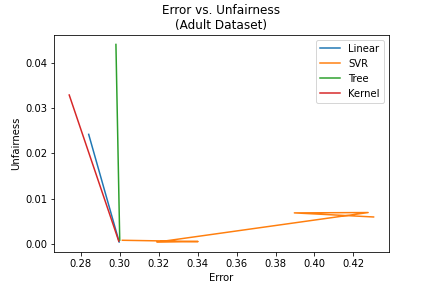

In [143]:
# set to 50 iterations for fast running of notebook - set >= 1000 when running real experiments
pareto_iters = 50
def multiple_classifiers_pareto(dataset, gamma_list=[0.002, 0.005, 0.01, 0.02, 0.05, 0.1], save_results=False, iters=pareto_iters):

    ln_predictor = linear_model.LinearRegression()
    svm_predictor = svm.LinearSVR()
    tree_predictor = tree.DecisionTreeRegressor(max_depth=3)
    kernel_predictor = KernelRidge(alpha=1.0, gamma=1.0, kernel='rbf')
    predictor_dict = {'Linear': {'predictor': ln_predictor, 'iters': iters},
                      'SVR': {'predictor': svm_predictor, 'iters': iters},
                      'Tree': {'predictor': tree_predictor, 'iters': iters},
                      'Kernel': {'predictor': kernel_predictor, 'iters': iters}}

    results_dict = {}

    for pred in predictor_dict:
        print('Curr Predictor: {}'.format(pred))
        predictor = predictor_dict[pred]['predictor']
        max_iters = predictor_dict[pred]['iters']
        fair_clf = GerryFairClassifier(C=100, printflag=True, gamma=1, predictor=predictor, max_iters=max_iters)
        fair_clf.printflag = False
        fair_clf.max_iters=max_iters
        errors, fp_violations, fn_violations = fair_clf.pareto(dataset, gamma_list)
        results_dict[pred] = {'errors': errors, 'fp_violations': fp_violations, 'fn_violations': fn_violations}
        plt.plot(errors, fp_violations, label=pred)

    if save_results:
        pickle.dump(results_dict, open('results_dict_' + str(gamma_list) + '_gammas' + str(gamma_list) + '.pkl', 'wb'))

    plt.xlabel('Error')
    plt.ylabel('Unfairness')
    plt.legend()
    plt.title('Error vs. Unfairness\n(Adult Dataset)')
    plt.savefig('gerryfair_pareto.png')
    plt.close()
multiple_classifiers_pareto(german_data_set)
Image(filename='gerryfair_pareto.png') 

A natural question one might ask is, suppose we fix a statistical fairness definition for rich subgroup fairness like equality of false positive rates, `FP`. Does learning a classifier that is fair with respect to `FP` increase or decrease fairness with respect to false negative rates `FN`? One could see this relationship going in either direction - and indeed we submit that it is dataset dependent. In some cases, if enforcing `FP` fairness pushes the classifier towards the constant classifier, then it will also satisify `FN` rate fairness, since the constant classifier is perfectly fair. However, if the hypothesis class is sufficiently rich, then one would expect that ceteris paribus since we are optimizing for error in addition to `FP` rate fairness, the algorithm would increase `FN` rate unfairness in order to decrease error. Below we trace the FN vs. FP rate tradeoff across a range of input $\gamma$, where the classifier is optimized only for `FP` rate fairness. 

gamma: 0.001  gamma: 0.002  gamma: 0.003  gamma: 0.004  gamma: 0.005  gamma: 0.0075  gamma: 0.01  gamma: 0.02  gamma: 0.03  gamma: 0.05  

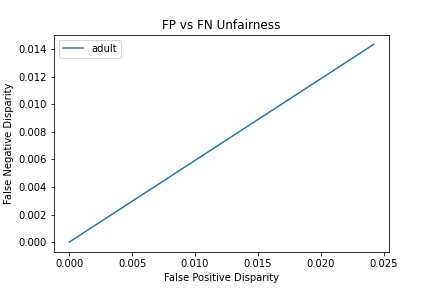

In [144]:
def fp_vs_fn(dataset, gamma_list, iters):
    fp_auditor = Auditor(dataset, 'FP')
    fn_auditor = Auditor(dataset, 'FN')
    fp_violations = []
    fn_violations = []
    for g in gamma_list:
        print('gamma: {} '.format(g), end =" ")
        fair_model = GerryFairClassifier(C=100, printflag=False, gamma=g, max_iters=iters)
        fair_model.gamma=g
        fair_model.fit(dataset)
        predictions = array_to_tuple((fair_model.predict(dataset)).labels)
        _, fp_diff = fp_auditor.audit(predictions)
        _, fn_diff = fn_auditor.audit(predictions)
        fp_violations.append(fp_diff)
        fn_violations.append(fn_diff)

    plt.plot(fp_violations, fn_violations, label='adult')
    plt.xlabel('False Positive Disparity')
    plt.ylabel('False Negative Disparity')
    plt.legend()
    plt.title('FP vs FN Unfairness')
    plt.savefig('gerryfair_fp_fn.png')
    plt.close()

gamma_list = [0.001, 0.002, 0.003, 0.004, 0.005, 0.0075, 0.01, 0.02, 0.03, 0.05]
fp_vs_fn(german_data_set, gamma_list, pareto_iters)
Image(filename='gerryfair_fp_fn.png')